Importing Libraries

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import geopandas as gpd
import plotly.express as px
import folium
from scipy.stats import shapiro, probplot
from statsmodels.stats.diagnostic import het_breuschpagan 
import geopandas as gpd
import pandas as pd
import plotly.express as px
import plotly.io as pio

CSV File 

In [ ]:
#do not run, this code has been updates. The final data set is now /Users/mona/final-project-monabr4/data/final_covid_data.csv

#state_covid_data = pd.read_csv('/Users/mona/final-project-monabr4/data/raw/state_covid_data.csv')
#population= pd.read_csv('/Users/mona/final-project-monabr4/data/raw/exported_statis_csv_shapefile/cleaned_population_data.csv')
#merged_data = pd.merge(population, state_covid_data, left_on='state', right_on='state')
#merged_data.drop(columns=['state'], inplace=True)
#merged_data

Basic Exploratory Analysis 

In [61]:
csv_file_path = "/Users/mona/final-project-monabr4/data/processed/final_covid_data.csv"
final_covid_data = pd.read_csv(csv_file_path)
(final_covid_data)
dimensions = final_covid_data.shape
print("Dimensions of the DataFrame:", dimensions)

Dimensions of the DataFrame: (16455, 13)


In [3]:
csv_file_path = "/Users/mona/final-project-monabr4/data/processed/final_covid_data.csv"
final_covid_data = pd.read_csv(csv_file_path)

columns_to_sum = [
    'cases_new', 'cases_recovered', 'cases_active',
    'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly',
    'population', 'cases_new_per_capita', 'cases_recovered_per_capita', 'cases_active_per_capita'
]
sum_by_state = final_covid_data.groupby('state')[columns_to_sum].sum()
sum_by_state

,cases_new,cases_recovered,cases_active,cases_child,cases_adolescent,cases_adult,cases_elderly,population,cases_new_per_capita,cases_recovered_per_capita,cases_active_per_capita
state,,,,,,,,,,,
Johor,398177,391453,5479342,50628,22241,282143,37160,4147757000,0.105310,0.103532,1.449178
Kedah,318502,316271,2952455,48605,23915,207425,32207,2397054700,0.145761,0.144740,1.351176
Kelantan,260024,258613,2523843,43695,24831,158211,32229,2091649900,0.136374,0.135634,1.323671
Melaka,144807,142071,2043934,17966,9239,102905,14194,1023171900,0.155256,0.152322,2.191416
Negeri Sembilan,230892,229259,2498197,28845,16484,160604,19831,1238293600,0.204546,0.203100,2.213144
Pahang,182590,181071,2271894,31076,13044,119960,17047,1841533900,0.108769,0.107864,1.353365
Perak,238885,236452,2360652,28007,14808,158333,33610,2753799100,0.095162,0.094193,0.940386
Perlis,18989,18761,217534,2650,974,12718,2623,279625300,0.074496,0.073601,0.853409
Pulau Pinang,307436,305317,2719952,32203,16076,223805,34682,1945639200,0.173340,0.172145,1.533577


In [ ]:
subset_sum_by_state = sum_by_state.iloc[:, [3, 4, 5,6]] 
subset_sum_by_state

In [ ]:
subset_sum_by_state = sum_by_state.iloc[:, [0, 1, 2]] 
subset_sum_by_state

In [ ]:
subset_sum_by_state = sum_by_state.iloc[:, [8]]  
subset_sum_by_state

How does the distribution of COVID-19 cases across different age groups vary among states in Malaysia?

In [62]:

final_covid_data

,Date,state,cases_new,cases_recovered,cases_active,cases_child,cases_adolescent,cases_adult,cases_elderly,population,cases_new_per_capita,cases_recovered_per_capita,cases_active_per_capita
0,2020-01-25,Johor,4,0,4,0,0,1,0,3781000,1.057921e-06,0.000000,0.000001
1,2020-01-26,Johor,0,0,4,0,0,0,0,3781000,0.000000e+00,0.000000,0.000001
2,2020-01-27,Johor,0,0,4,0,0,0,0,3781000,0.000000e+00,0.000000,0.000001
3,2020-01-28,Johor,0,0,4,0,0,0,0,3781000,0.000000e+00,0.000000,0.000001
4,2020-01-29,Johor,2,0,6,0,0,2,0,3781000,5.289606e-07,0.000000,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16450,2023-01-21,W.P. Putrajaya,6,9,267,0,0,6,0,110000,5.454545e-05,0.000082,0.002427
16451,2023-01-22,W.P. Putrajaya,5,8,264,0,0,5,0,110000,4.545455e-05,0.000073,0.002400
16452,2023-01-23,W.P. Putrajaya,7,4,267,0,0,6,1,110000,6.363636e-05,0.000036,0.002427
16453,2023-01-24,W.P. Putrajaya,1,4,264,0,0,1,0,110000,9.090909e-06,0.000036,0.002400


In [5]:
#Most Populated to Least Populates
population_mode_by_state = final_covid_data.groupby('state')['population'].agg(lambda x: x.mode().iloc[0]).reset_index()
ranked_states = population_mode_by_state.sort_values(by='population', ascending=False).reset_index(drop=True)
desired_order = ranked_states['state'].tolist()
print(desired_order)


['Selangor', 'Sabah', 'Johor', 'Sarawak', 'Perak', 'Kedah', 'Kelantan', 'W.P. Kuala Lumpur', 'Pulau Pinang', 'Pahang', 'Terengganu', 'Negeri Sembilan', 'Melaka', 'Perlis', 'W.P. Putrajaya']


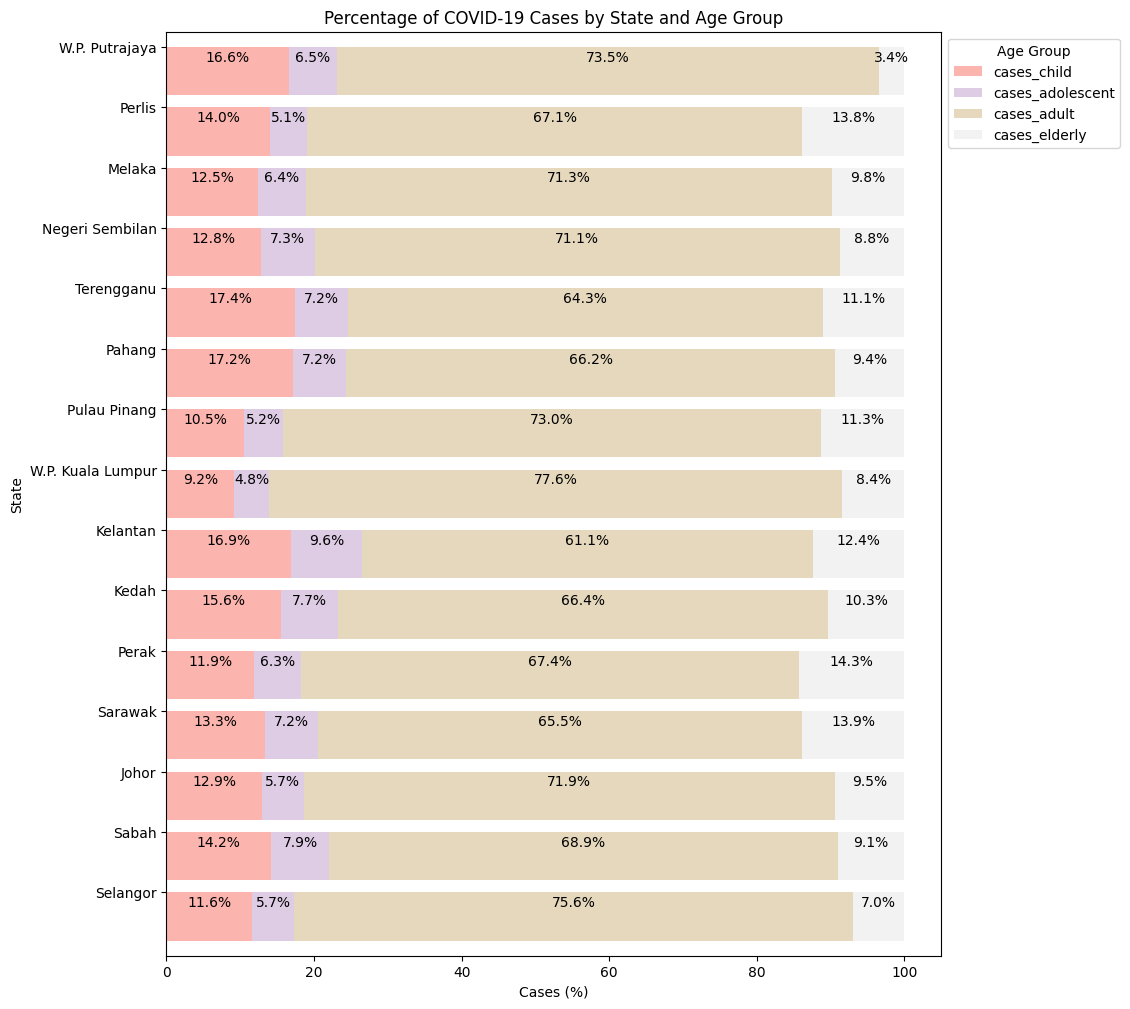

In [17]:
selected_columns = ['state', 'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly']
selected_df = final_covid_data[selected_columns]
total_by_state = selected_df.groupby('state').sum()

desired_state_order = ['Selangor', 'Sabah', 'Johor', 'Sarawak', 'Perak', 'Kedah', 'Kelantan', 'W.P. Kuala Lumpur', 'Pulau Pinang', 'Pahang', 'Terengganu', 'Negeri Sembilan', 'Melaka', 'Perlis', 'W.P. Putrajaya']

total_by_state = total_by_state.reindex(desired_state_order)


total_by_state_percentage = total_by_state.div(total_by_state.sum(axis=1), axis=0) * 100


ax = total_by_state_percentage.plot(kind='barh', figsize=(10, 12), width=0.8, position=1, colormap='Pastel1', stacked=True)


plt.title('Percentage of COVID-19 Cases by State and Age Group')
plt.xlabel('Cases (%)')
plt.ylabel('State')
plt.legend(title='Age Group', loc='upper left', bbox_to_anchor=(1, 1))


for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{width:.1f}%', (x + width / 2., y + height / 2.),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.savefig('/Users/mona/final-project-monabr4/results/covid_percentage_by_state.png', bbox_inches='tight')




GRAPHING USING THE SHAPEFILE

How do COVID-19 incidence rates vary across different states in Malaysia?: Interactive Plot of New Covid Cases Over Time 

In [ ]:
#static is a screenshot of the HTML 

In [ ]:
import geopandas as gpd
import pandas as pd
import plotly.express as px
import plotly.io as pio


geojson_file = "/Users/mona/final-project-monabr4/data/processed/final_malaysia_shapefile_data.geojson"
gdf = gpd.read_file(geojson_file)


df = final_covid_data[['Date', 'state', 'cases_new']]
df['Date'] = pd.to_datetime(df['Date'])

grouped_data = df.groupby(['Date', 'state'])['cases_new'].sum().reset_index()

state_colors = {
    'Johor': 'red',
    'Kedah': 'blue',
    'Kelantan': 'green',
    'Melaka': 'purple',
    'Negeri Sembilan': 'orange',
    'Pahang': 'pink',
    'Perak': 'brown',
    'Perlis': 'gray',
    'Pulau Pinang': 'cyan',
    'Sabah': 'magenta',
    'Sarawak': 'yellow',
    'Selangor': 'lime',
    'Terengganu': 'teal',
    'W.P. Kuala Lumpur': 'olive',
    'W.P. Labuan': 'navy',
    'W.P. Putrajaya': 'maroon'
}

# Create an interactive line plot with custom colors
fig = px.line(grouped_data, x='Date', y='cases_new', color='state',
              title='COVID-19 Cases Over Time for Each State',
              labels={'cases_new': 'New Cases', 'Date': 'Date'},
              line_group='state',
              color_discrete_map=state_colors)

fig.write_html("/Users/mona/final-project-monabr4/results/interactive_new_cases_by_state.html")




Are there significant disparities in the impact of the pandemic on various regions in terms of cases and recoveries?

In [66]:
import folium
import geopandas as gpd
from folium import plugins


geojson_file = "/Users/mona/final-project-monabr4/data/processed/final_rate_data.geojson"
geo_data = gpd.read_file(geojson_file)


m = folium.Map(location=[4.2105, 101.9758], zoom_start=6)


color_scale = folium.StepColormap(
    colors=['#f7f7f7', '#984ea3', '#4d004b'],
    vmin=geo_data['percentage_living'].min(),
    vmax=geo_data['percentage_living'].max(),
    caption='Percentage Living'
)

folium.GeoJson(
    geo_data,
    name='COVID-19 Information',
    style_function=lambda feature: {
        'fillColor': color_scale(feature['properties']['percentage_living']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    highlight_function=lambda x: {'weight': 3, 'color': 'black'},
    tooltip=folium.GeoJsonTooltip(
        fields=['name', 'cases_new', 'cases_recovered', 'percent_recovered', "percent_not_recovered", "percentage_living"],
        aliases=['State', 'Total Cases', 'Recovered', 'Percent Recovered', "Percent Not Recovered", "Percent of the population in Malaysia"],
        localize=True
    )
).add_to(m)


m.add_child(color_scale)

m.save("/Users/mona/final-project-monabr4/results/recovered_rate_map.html")


Is there a correlation between population density in different states and the rate of COVID-19 transmission?

NameError: name 'pearsonr' is not defined

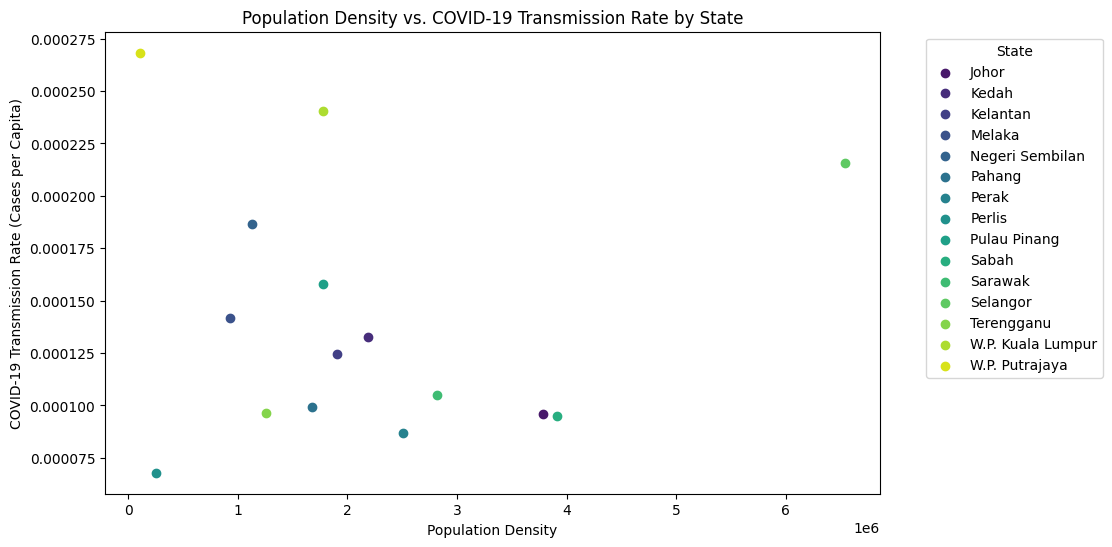

In [64]:
selected_columns = ['state', 'population', 'cases_new_per_capita']
data_to_plot = final_covid_data[selected_columns]

mean_data = data_to_plot.groupby('state').mean()

plt.figure(figsize=(10, 6))
palette = sns.color_palette('viridis', len(mean_data))

for i, (state, row) in enumerate(mean_data.iterrows()):
    color = palette[i]
    plt.scatter(row['population'], row['cases_new_per_capita'], color=color, marker='o', label=state)

plt.title('Population Density vs. COVID-19 Transmission Rate by State')
plt.xlabel('Population Density')
plt.ylabel('COVID-19 Transmission Rate (Cases per Capita)')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')


correlation_coefficient, _ = pearsonr(mean_data['population'], mean_data['cases_new_per_capita'])
print(f"Pearson correlation coefficient: {correlation_coefficient}")

plt.show()


Statistics on cases_new_per_capita vs overall populaiton for each state 

In [ ]:

#homesceda





In [58]:
#linearity 
residuals = mean_data['cases_new_per_capita'] - (intercept + slope * mean_data['population'])

statistic, p_value_shapiro = shapiro(residuals)
print(f"Shapiro-Wilk Test for Normality:")
print(f"Test Statistic: {statistic}")
print(f"P-value: {p_value_shapiro}")

probplot(residuals, plot=plt)
plt.title('Probability Plot of Residuals')
plt.show()


NameError: name 'mean_data' is not defined

In [ ]:
# if the asssumptions have not been met 
selected_columns = ['state', 'population', 'cases_new_per_capita']
data_to_plot = final_covid_data[selected_columns]

mean_data = data_to_plot.groupby('state').mean()

plt.figure(figsize=(10, 6))
palette = sns.color_palette('viridis', len(mean_data))

for i, (state, row) in enumerate(mean_data.iterrows()):
    color = palette[i]
    plt.scatter(row['population'], row['cases_new_per_capita'], color=color, marker='o', label=state)

plt.title('Population Density vs. COVID-19 Transmission Rate by State')
plt.xlabel('Population Density')
plt.ylabel('COVID-19 Transmission Rate (Cases per Capita)')

plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left')


spearman_corr, p_value_spearman = spearmanr(mean_data['population'], mean_data['cases_new_per_capita'])
print(f"Spearman's Correlation Results:")
print(f"Spearman's Correlation Coefficient: {spearman_corr}")
print(f"P-value: {p_value_spearman}")


if p_value_spearman < 0.05:
    print("The relationship is statistically significant.")
else:
    print("The relationship is not statistically significant.")

plt.show()
